In [1]:
# import libraries
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime as dt
import pandas as pd
import numpy as np

# never print matching warnings
import warnings
warnings.filterwarnings('ignore')

# classic division semantics in a module
from __future__ import division

#for data visualization
import plotly.offline as pyoff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# initiate the Plotly Notebook mode to use plotly offline
init_notebook_mode(connected=True)

In [3]:
# load sales data to dataframe
data = pd.read_csv('OnlineRetail.csv',header=0, encoding = 'unicode_escape')
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50,4.95,12680.0,France


In [4]:
# seeing full summary of the retail data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# there are null data in description and the CustomerID columns
# check null totals
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# clean null data and get data statistics summarize 
dropna = data.dropna(subset=['CustomerID'])
dropna.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# check duplicates data
dropna.duplicated().sum()

5225

In [8]:
# clean duplicated data and get data statistics summarize 
dropdup = dropna.drop_duplicates()
dropdup.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# the min for unit price = 0 and the min for Quantity is a negative value
# clean up negative values most likely from refunds
retail_data=dropdup[(dropdup['Quantity'] > 0) & (dropdup['UnitPrice'] > 0)]
retail_data.describe() 

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [10]:
# checking data set size
retail_data.shape

(392692, 8)

In [11]:
# convert InvoiceDate to datetime
retail_data['InvoiceMonth'] = pd.DatetimeIndex(retail_data.InvoiceDate).date
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01


In [12]:
# restricting data to the United Kingdom only since it has the most customers
uk_data = retail_data.loc[retail_data['Country'] == 'United Kingdom']
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,2010-12-01


In [13]:
# calculate monthly revenue and create a new dataframe with InvoiceMonth and Revenue columns
uk_data['Revenue'] = uk_data['UnitPrice'] * uk_data['Quantity']
uk_data = uk_data.groupby(['InvoiceMonth'])['Revenue'].sum().round().reset_index()
uk_data.head()

,InvoiceMonth,Revenue
0,2010-12-01,42050.0
1,2010-12-02,47020.0
2,2010-12-03,18791.0
3,2010-12-05,25440.0
4,2010-12-06,29501.0


In [14]:
# check invoice month data type
uk_data.dtypes

InvoiceMonth     object
Revenue         float64
dtype: object

In [15]:
# convert invoice month to dt
uk_data['InvoiceMonth'] = pd.to_datetime(uk_data.InvoiceMonth)
uk_data.dtypes

InvoiceMonth    datetime64[ns]
Revenue                float64
dtype: object

In [16]:
# rename the columns to ds and y in order to comply with the prophet API
uk_revenue = uk_data.rename(columns = {"InvoiceMonth" : 'ds', "Revenue" : 'y'})
uk_revenue.shape
uk_revenue.head()

,ds,y
0,2010-12-01,42050.0
1,2010-12-02,47020.0
2,2010-12-03,18791.0
3,2010-12-05,25440.0
4,2010-12-06,29501.0


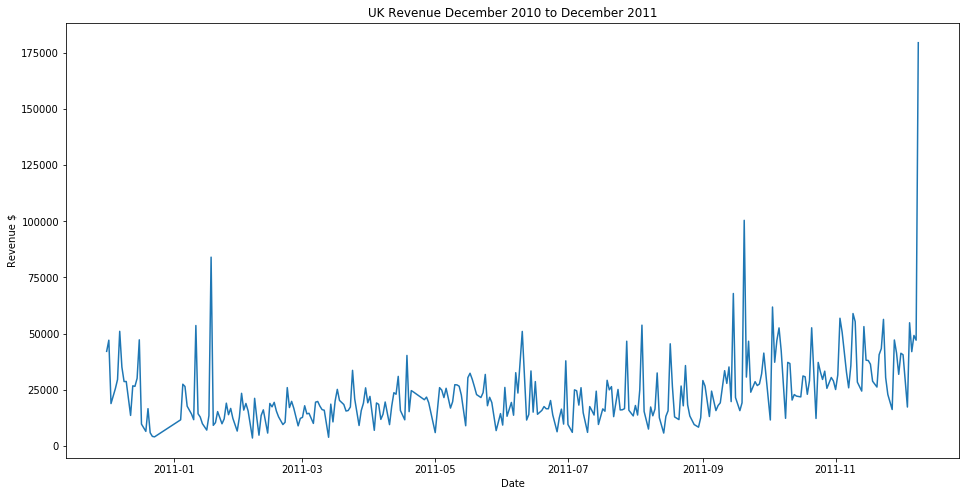

In [17]:
# graph uk revenue
fig = plt.figure(facecolor='w', figsize=(16,8))
plt.title('UK Revenue December 2010 to December 2011')
plt.xlabel('Date')
plt.ylabel('Revenue $')
plt.plot(uk_revenue.ds, uk_revenue.y)

In [18]:
# prepare our model to make future predictions
# guiding principle of Phrphet's approach is General Additive Models (GAMs)
# set the uncertainty interval to 95% (interval_width=0.95)(the Prophet default is 80%)
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.add_country_holidays(country_name='UK')
model.fit(uk_revenue)
future = model.make_future_dataframe(periods = 180)

In [19]:
# check tail of future to ensure the prediction dates are 180 days out
future.tail()

,ds
480,2012-06-02
481,2012-06-03
482,2012-06-04
483,2012-06-05
484,2012-06-06


In [20]:
# check tail of uk revenue to see the last purcahse dates
uk_revenue.tail()

,ds,y
300,2011-12-05,54792.0
301,2011-12-06,41915.0
302,2011-12-07,49130.0
303,2011-12-08,47024.0
304,2011-12-09,179543.0


In [21]:
# predict method to make future predictions.
# this will generate a dataframe with a yhat column that will contain the predictions
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,35369.989459,7690.319234,40055.098563,35369.989459,35369.989459,0.0,0.0,0.0,0.0,...,195.678539,195.678539,195.678539,14635.305346,14635.305346,14635.305346,0.0,0.0,0.0,23661.090787
1,2010-12-02,35448.902706,13642.022495,46053.353639,35448.902706,35448.902706,0.0,0.0,0.0,0.0,...,4965.715218,4965.715218,4965.715218,16017.667885,16017.667885,16017.667885,0.0,0.0,0.0,29892.403252
2,2010-12-03,35527.815952,10580.338787,41807.722749,35527.815952,35527.815952,0.0,0.0,0.0,0.0,...,-546.055404,-546.055404,-546.055404,17286.116545,17286.116545,17286.116545,0.0,0.0,0.0,25727.994536
3,2010-12-05,35685.642444,1354.163265,33752.298036,35685.642444,35685.642444,0.0,0.0,0.0,0.0,...,-10582.525898,-10582.525898,-10582.525898,19373.876866,19373.876866,19373.876866,0.0,0.0,0.0,17937.110856
4,2010-12-06,35764.555690,12941.268130,44226.941893,35764.555690,35764.555690,0.0,0.0,0.0,0.0,...,-607.564677,-607.564677,-607.564677,20147.062347,20147.062347,20147.062347,0.0,0.0,0.0,28764.170803


In [22]:
# mainly interested in ds, yhat, yhat_lower, and yhat_upper
# yhat is our predicted forecast, yhat_lower is the lower bound for our predictions, and yhat_upper is the upper bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
480,2012-06-02,55080.287501,40123.311797,70900.859207
481,2012-06-03,41414.231688,25089.992396,55815.686697
482,2012-06-04,51589.192739,35856.447896,66573.959368
483,2012-06-05,55609.943394,39720.029173,70680.550531
484,2012-06-06,52651.239681,35471.441623,68647.770588


In [23]:
# check the head of the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-12-01,23661.090787,7690.319234,40055.098563
1,2010-12-02,29892.403252,13642.022495,46053.353639
2,2010-12-03,25727.994536,10580.338787,41807.722749
3,2010-12-05,17937.110856,1354.163265,33752.298036
4,2010-12-06,28764.170803,12941.268130,44226.941893


In [24]:
# check the tail of the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
480,2012-06-02,55080.287501,40123.311797,70900.859207
481,2012-06-03,41414.231688,25089.992396,55815.686697
482,2012-06-04,51589.192739,35856.447896,66573.959368
483,2012-06-05,55609.943394,39720.029173,70680.550531
484,2012-06-06,52651.239681,35471.441623,68647.770588


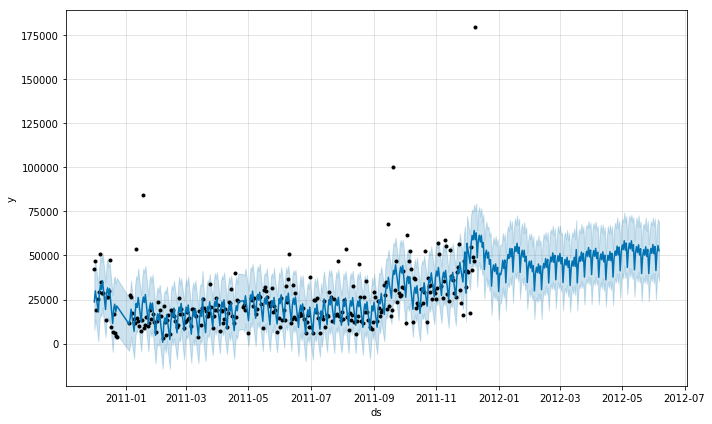

In [25]:
# plot forcast
# blue line represents the predicted values
# shaded blue area is the error of the forecast 
# the black dots represents the data in our dataset
plot2 = model.plot(forecast)

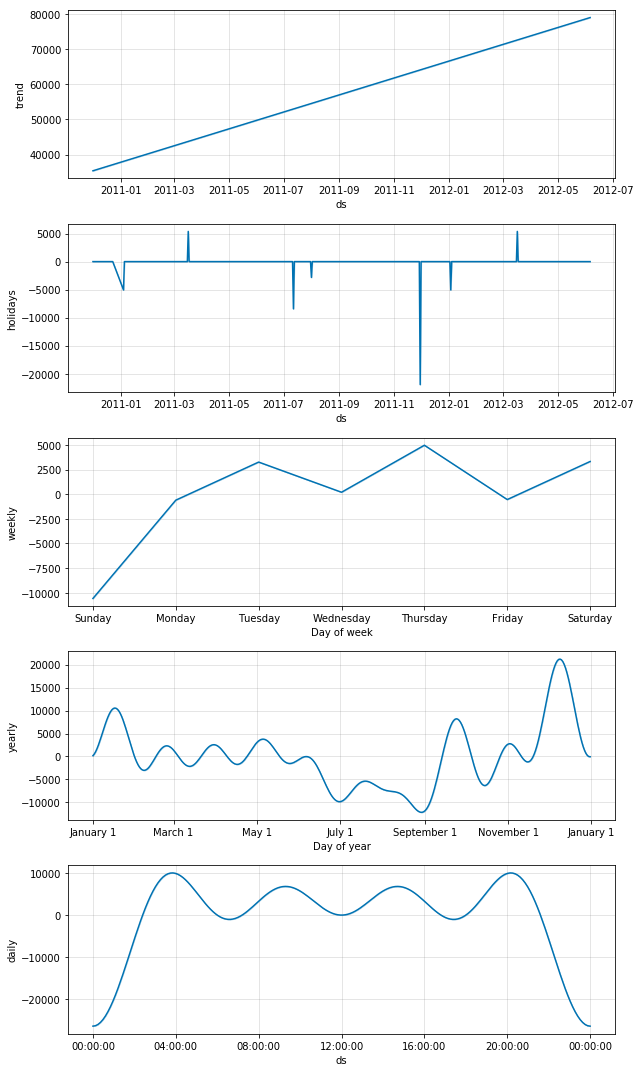

In [26]:
# plots the trend, yearly, weekly and daily seasonality
plot3 = model.plot_components(forecast)

In [27]:
metric_df = forecast.set_index('ds')[['yhat']].join(uk_revenue.set_index('ds').y).reset_index()
metric_df.tail()

,ds,yhat,y
480,2012-06-02,55080.287501,NaN
481,2012-06-03,41414.231688,NaN
482,2012-06-04,51589.192739,NaN
483,2012-06-05,55609.943394,NaN
484,2012-06-06,52651.239681,NaN


In [28]:
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
300,2011-12-05,56491.559421,54792.0
301,2011-12-06,61257.176018,41915.0
302,2011-12-07,58895.367386,49130.0
303,2011-12-08,64150.119625,47024.0
304,2011-12-09,58898.677490,179543.0


In [29]:
# R-Squared value
r2_score(metric_df.y, metric_df.yhat)

0.4203062468230063

In [30]:
mean_squared_error(metric_df.y, metric_df.yhat)

151215420.3102458

In [31]:
mean_absolute_error(metric_df.y, metric_df.yhat)

7534.0220316859

In [32]:
# this dataset is not ideal for timeseries modeling and the metrics proves that